<a href="https://colab.research.google.com/github/lhw0772/deepstock/blob/master/onecode_predict_kospi_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 유틸 로드

ctrl +F5 : 구글드라이브 마운트
ctrl +F9 : 모든 코드 실행

2. 데이터 저장 / 읽기


In [0]:
from sklearn import preprocessing 
import pandas as pd
import io
import os
import datetime
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt 

DEBUG = 1

KOSPI_LIST_FILE= 'drive/My Drive/kospi/data/kospi_list.csv'
KOSPI_DATA_ROOT= 'drive/My Drive/kospi/data/'

TRAIN_START=datetime.datetime(2015, 1, 1)
TRAIN_END=datetime.datetime(2018, 12, 31)

TEST_START=datetime.datetime(2019, 1, 1)
TEST_END=datetime.datetime(2020, 1, 1)

def get_stock_hist(code,start,end):

  if(DEBUG):
    print (code)
  try :
    info = pdr.get_data_yahoo(code, 
                          start=start, 
                          end=end)
  except:
    if(DEBUG):
      print('no data, skip')
    df_empty = pd.DataFrame({'A' : []})
    return df_empty

  return info

def save_preproc_kospi(kospi_list,_start,_end,_period,_filename):
  start = _start
  end = _end
  period = _period
  min_max_scaler = preprocessing.MinMaxScaler()

  train_x =[]
  train_y =[]

  valid_x =[]
  valid_y =[]

  test_x =[]
  test_y =[]

  code_cnt = 0
  total_code_num = len(kospi_list)

  for code in kospi_list:

    print (str(code_cnt)+"/"+str(total_code_num))
  
    if(code.isdigit() == True):

      hist=get_stock_hist(code+'.KS',start,end)

      if(hist.empty):
        continue

      total_len=len(hist)
      start_idx =0
      end_idx =start_idx+period+1

      code_cnt +=1 

      while end_idx < total_len:
        split_data=hist[start_idx:end_idx] ## start_idx ~ end_idx  # 0~30 
        feature = split_data.iloc[:,4:6] ## adj_close, volume
        scaled_feature = min_max_scaler.fit_transform(feature)
        label = scaled_feature[30][1] - scaled_feature[29][1]

        if(DEBUG>1 and end_idx ==31):
          plt.plot(scaled_feature)
          plt.show()

        if(label >0):
          label = 1
        else:
          label = 0

        start_idx +=1
        end_idx +=1

        train_x.append(scaled_feature[:-1])
        train_y.append(label)

  train_x = np.array(train_x)
  train_y = np.array(train_y)

  print (train_x.shape)
  print (train_y.shape)

  np.save(_filename+"_x",train_x)
  np.save(_filename+"_y",train_y)

def make_data(period,d_name):

  kospi_list = pd.read_csv(KOSPI_LIST_FILE,error_bad_lines=False)['종목코드']
  print ('training data making')
  period = period

  folder_path = os.path.join(KOSPI_DATA_ROOT,d_name)

  if(os.path.exists(folder_path)==False):
    os.mkdir(folder_path)

  save_preproc_kospi(kospi_list,TRAIN_START,TRAIN_END,period,os.path.join(folder_path,'train'))

  print ('testing data making')
  period = period
  save_preproc_kospi(kospi_list,TEST_START,TEST_END,period,os.path.join(folder_path,'test'))


def load_data(d_name):

  folder_path = os.path.join(KOSPI_DATA_ROOT,d_name)

  kospi_train_x = np.load(os.path.join(folder_path,'train_x.npy'))
  kospi_train_y = np.load(os.path.join(folder_path,'train_y.npy'))

  kospi_test_x = np.load(os.path.join(folder_path,'test_x.npy'))
  kospi_test_y = np.load(os.path.join(folder_path,'test_y.npy'))

  kospi_train_y=to_categorical(kospi_train_y)
  kospi_test_y=to_categorical(kospi_test_y)


  return [kospi_train_x,kospi_train_y,kospi_test_x,kospi_test_y]



3. 모델 로드


In [3]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import os
from keras.models import model_from_json

KOSPI_MODEL_ROOT= 'drive/My Drive/kospi/model'

def save_model_arch(model,model_name):
  model_json = model.to_json()
  with open(model_name, "w") as json_file : 
    json_file.write(model_json)

def create_lstm_v1():
  inputs = Input(shape=(30,2))
  lstm1 = LSTM(units=50, return_sequences=True)(inputs)
  dropout1 = Dropout(0.2)(lstm1)
  lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
  dropout2 = Dropout(0.2)(lstm2)
  lstm3 = LSTM(units=50)(dropout2)
  dropout3 = Dropout(0.2)(lstm3)
  softmax = Dense(units=2,activation='softmax')(dropout3)

  model = Model(inputs=inputs, outputs=softmax)

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
  metrics=['accuracy'])

  return model

def make_model(model_name):
    if model_name == 'm1':
      model=create_lstm_v1()
      folder_path= os.path.join(KOSPI_MODEL_ROOT,model_name)

      if(os.path.exists(folder_path)==False):
        os.mkdir(folder_path)
      save_model_arch(model,os.path.join(folder_path,model_name+".json"))

def load_model_arch(model_name):
  real_path=os.path.join(KOSPI_MODEL_ROOT,model_name,model_name+".json")
  json_file = open(real_path)
  loaded_model_json=json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  loaded_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
  metrics=['accuracy'])
  return loaded_model

def load_model_ckpt (nodel_arch,model_name,_epoch):
  ckpt = os.path.join(KOSPI_MODEL_ROOT,model_name,'model-{epoch:04d}.h5')
  nodel_arch.load_weights(ckpt.format(epoch=_epoch),by_name=True)
  return nodel_arch


#make_model('m1')
#model = load_model_arch('m1')



Using TensorFlow backend.


4. 학습

In [0]:

KOSPI_MODEL_ROOT= 'drive/My Drive/kospi/model'


def train_model(ckpt_model_name,model,data,epoch,batch_size,initial_epoch):
  
  ckpt_path = os.path.join(KOSPI_MODEL_ROOT,ckpt_model_name,'model-{epoch:04d}.h5')

  cp_callback = ModelCheckpoint(
    ckpt_path, verbose=1, save_weights_only=True,
    period=1)

  hist = model.fit(data[0],data[1],batch_size=batch_size,
                   validation_split=0.3, 
                   epochs=epoch,
                   initial_epoch=initial_epoch,
                   callbacks = [cp_callback],validation_freq=1)
  
  return hist

5.분석


In [0]:
def disp_hist(hist):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='upper left')

  acc_ax.plot(hist.history['acc'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='upper left')

plt.show()

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

KOSPI_MODEL_ROOT= 'drive/My Drive/kospi/model'

def draw_pr_curve(model_name,test_x,test_y,_epoch,th):

    test_x=test_x[:,:,:]
    test_y=test_y[:]

    model=load_model_arch(model_name)
    model=load_model_ckpt(model,model_name,_epoch)

    predict = model.predict(test_x)
    y_scores=predict[:,1]
    y_true=test_y[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.show()

    idx= np.where(recall<th)[0][0]

    print('precision')
    print (precision[idx])
    print ('recall')
    print (recall[idx])
    print ('threhold')
    print (thresholds[idx])

    return precision[idx],recall[idx],thresholds[idx]



#draw_pr_curve('m1',data[2],data[3],1,0.1)

6. 백테스팅

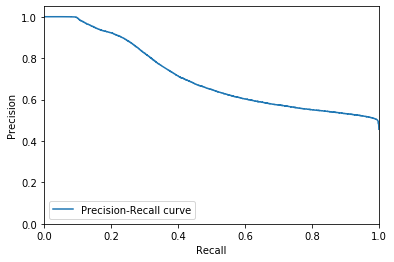

precision
0.8237094024566158
recall
0.2999872643912379
threhold
0.5532613


(0.8237094024566158, 0.2999872643912379, 0.5532613)

In [25]:
data=load_data('d1')
#draw_pr_curve('m1',data[2],data[3],1,0.1)
draw_pr_curve('m1',data[2],data[3],2,0.3)

In [0]:

# model loaded
model=load_model_arch('m1')
model=load_model_ckpt(model,'m1',2)
opt_th = 0.9

def get_stock_hist_exact(code,start,end):
  try :
    info = pdr.get_data_yahoo(code, 
                        start=start, 
                        end=end)
  except:
    df_empty = pd.DataFrame({'A' : []})
    return df_empty

  info = info.loc[start:end]
  return info

def is_dayoff(day):

  holidays=['2019-12-25','2019-12-31','2020-01-01','2020-01-24','2020-01-27']
  
  if((day.weekday()==5) or (day.weekday()==6) or (day.strftime('%Y-%m-%d') in holidays)):
    return True
  else:
    #print (day,day in holidays)
    return False

def is_buy(model,th,code,start,end): # code, (30,2) feature
   hist = get_stock_hist_exact(code,start,end)

   if(hist.empty):
    return 0,0
   #print (hist)
   #print (code)
   feature = hist.iloc[:-1,4:6]
   if(feature.shape[0]!=30):
     return 0,0

   min_max_scaler = preprocessing.MinMaxScaler()
   scaled_feature = min_max_scaler.fit_transform(feature)

   scaled_feature= np.array([scaled_feature])
   pred=get_result(model,scaled_feature,th)

   cur_val = hist.iloc[-2,5]
   future_val = hist.iloc[-1,5]

   profit = (future_val-cur_val)

   return pred,profit

def get_result(model,scaled_feature,th):
  result = model.predict(scaled_feature, verbose=0)
  result = result > th
  pred = result[0,1]

  return pred

def back_test_onecode(code,start_datetime,end_datetime,model,th):
  acc_val = 0
  correct = 0
  buy_cnt =0
  win_ratio= 0

  while(True):
  
    while(is_dayoff(start_datetime)):
      start_datetime += datetime.timedelta(days=1)
      
    while(is_dayoff(end_datetime)):
      end_datetime += datetime.timedelta(days=1)

    print (str(start_datetime) +"~"+str(end_datetime))
    buy,val=is_buy(model,th,code,start_datetime,end_datetime)

    if(buy):
      acc_val+=val
      buy_cnt+=1
      if(val>0):
        correct+=1
        win_ratio= (correct/buy_cnt)


    print (buy,val,acc_val,win_ratio)

    start_datetime += datetime.timedelta(days=1)
    end_datetime += datetime.timedelta(days=1)

def back_test_multicode(list,start_datetime,end_datetime,model,th):
    #just test one day

  acc_val = 0
  correct = 0
  buy_cnt =0
  win_ratio= 0

  while(True):
  
    while(is_dayoff(start_datetime)):
      start_datetime += datetime.timedelta(days=1)
      
    while(is_dayoff(end_datetime)):
      end_datetime += datetime.timedelta(days=1)

    print (str(start_datetime) +"~"+str(end_datetime))

    for code in kospi_list:
      # if(cnt<59):
      #   cnt+=1
      #   continue
      buy,val=is_buy(model,th,code+".KS",start_datetime,end_datetime)

      if(buy):
        print ('buy!')
        print (code,val)
        acc_val+=val

        buy_cnt+=1
        if(val>0):
          correct+=1
          win_ratio= (correct/buy_cnt)
        
    
    print (acc_val,win_ratio)
    start_datetime += datetime.timedelta(days=1)
    end_datetime += datetime.timedelta(days=1)


start_year= 2019
start_month=11
start_day=18

end_year=2020
end_month=1
end_day=2

ss = datetime.datetime(start_year, start_month, start_day)
se = datetime.datetime(end_year, end_month, end_day)
kospi_list = pd.read_csv(KOSPI_LIST_FILE,error_bad_lines=False)['종목코드']

back_test_multicode(kospi_list,ss,se,model,opt_th)
#back_test_onecode('079160.KS',ss,se,model,opt_th)


b'Skipping line 442: expected 12 fields, saw 13\n'


2019-11-18 00:00:00~2020-01-02 00:00:00
